In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from R32_bmimPF6_PR import configuration
data = pd.read_csv('R32IL.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

# for linear
# m.fs.properties.PR_kappa_A['bmimPF6', 'R32'].fix(0.2680396)
# m.fs.properties.PR_kappa_A['R32', 'bmimPF6'].fix(0.0270027)
# m.fs.properties.PR_kappa_B['bmimPF6', 'R32'].fix(-0.315399)
# m.fs.properties.PR_kappa_B['R32', 'bmimPF6'].fix(-0.0487913)

# for constant
# m.fs.properties.PR_kappa_A['bmimPF6', 'R32'].fix(-0.07040532395154804)
# m.fs.properties.PR_kappa_A['R32', 'bmimPF6'].fix(-0.026088350772152862)
# m.fs.properties.PR_kappa_B['bmimPF6', 'R32'].fix(0.0)
# m.fs.properties.PR_kappa_B['R32', 'bmimPF6'].fix(0.0)

#for ternary
# m.fs.properties.PR_kappa_A['bmimPF6', 'R32'].fix(-0.3505701)
# m.fs.properties.PR_kappa_A['R32', 'bmimPF6'].fix(-0.0435076)
# m.fs.properties.PR_kappa_B['bmimPF6', 'R32'].fix(0.0)
# m.fs.properties.PR_kappa_B['R32', 'bmimPF6'].fix(0.0)

#for ternary weighted
# m.fs.properties.PR_kappa_A['bmimPF6', 'R32'].fix(-0.1130500)
# m.fs.properties.PR_kappa_A['R32', 'bmimPF6'].fix(-0.032831)
# m.fs.properties.PR_kappa_B['bmimPF6', 'R32'].fix(0.0)
# m.fs.properties.PR_kappa_B['R32', 'bmimPF6'].fix(0.0)


# for M5

m.fs.properties.PR_kappa_A['bmimPF6', 'R32'].fix(-0.010645)
m.fs.properties.PR_kappa_A['R32', 'bmimPF6'].fix(-0.024842)
m.fs.properties.PR_kappa_B['bmimPF6', 'R32'].fix(-0.09102)
m.fs.properties.PR_kappa_B['R32', 'bmimPF6'].fix(-0.00556)

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].unfix()

R32_x = np.zeros((len(data)))
P = np.zeros((len(data)))


In [4]:
print(data["x_bmimPF6"])

0     0.9794
1     0.8940
2     0.7290
3     0.5720
4     0.4420
5     0.3500
6     0.1850
7     0.9820
8     0.9240
9     0.8100
10    0.7030
11    0.6100
12    0.5250
13    0.4480
14    0.3720
15    0.9940
16    0.9530
17    0.8870
18    0.8260
19    0.7690
20    0.7150
21    0.6650
22    0.6180
23    0.9970
24    0.9710
25    0.9300
26    0.8910
27    0.8540
28    0.8180
29    0.7860
30    0.7520
Name: x_bmimPF6, dtype: float64


In [5]:
bmim = np.linspace(data["x_bmimPF6"].iloc[6], data["x_bmimPF6"].iloc[0], 15)

P = np.zeros((len(bmim)))
P0 = np.zeros((len(bmim)))
R32_x1 = np.zeros((len(bmim)))
m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"] == m.fs.liq)

for i in range(len(bmim)-1):
    print(i)
    m.fs.liq = bmim[i]
    a = bmim[i]
    b = 1-(bmim[i])
    P0[i] = 1065612.69*b - 25429
    m.fs.F101.inlet.temperature.fix(283.001)
    m.fs.F101.inlet.pressure.fix(P0[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(1-(bmim[i]-0.1))
    m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(bmim[i]-0.1)
    m.fs.F101.vap_outlet.temperature.fix(283.001)
    m.fs.F101.vap_outlet.pressure.fix(P0[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R32_x1[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R32_x1[i] = "NaN"
            P[i] = "NaN"

bmim2 = np.linspace(data["x_bmimPF6"].iloc[14], data["x_bmimPF6"].iloc[7], 15)

P2 = np.zeros((len(bmim2)))
P02 = np.zeros((len(bmim2)))
R32_x2 = np.zeros((len(bmim2)))

for i in range(len(bmim2)-1):
    print(i)
    m.fs.liq = bmim2[i]
    a = bmim2[i]
    b = 1-(bmim2[i])
    P02[i] = 1597168.40*b - 42033.03
    m.fs.F101.inlet.temperature.fix(298.001)
    m.fs.F101.inlet.pressure.fix(P02[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(1-(bmim2[i]-0.1))
    m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(bmim2[i]-0.1)
    m.fs.F101.vap_outlet.temperature.fix(298.001)
    m.fs.F101.vap_outlet.pressure.fix(P02[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R32_x2[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P2[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R32_x2[i] = "NaN"
            P2[i] = "NaN"
            
bmim3 = np.linspace(data["x_bmimPF6"].iloc[22], data["x_bmimPF6"].iloc[15], 15)

P3 = np.zeros((len(bmim3)))
P03 = np.zeros((len(bmim3)))
R32_x3 = np.zeros((len(bmim3)))

for i in range(len(bmim3)-1):
    print(i)
    m.fs.liq = bmim3[i]
    a = bmim3[i]
    b = 1-(bmim3[i])
    P03[i] = 2617034.37*b - 32449.38
    m.fs.F101.inlet.temperature.fix(323.001)
    m.fs.F101.inlet.pressure.fix(P03[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(1-(bmim3[i]-0.1))
    m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(bmim3[i]-0.1)
    m.fs.F101.vap_outlet.temperature.fix(323.001)
    m.fs.F101.vap_outlet.pressure.fix(P03[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R32_x3[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P3[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R32_x3[i] = "NaN"
            P3[i] = "NaN"
            
bmim4 = np.linspace(data["x_bmimPF6"].iloc[30], data["x_bmimPF6"].iloc[24], 15)

P4 = np.zeros((len(bmim4)))
P04 = np.zeros((len(bmim4)))
R32_x4 = np.zeros((len(bmim4)))

for i in range(len(bmim4)-1):
    print(i)
    m.fs.liq = bmim4[i]
    a = bmim4[i]
    b = 1-(bmim4[i])
    P04[i] = 4040154.79*b - 23336.87
    m.fs.F101.inlet.temperature.fix(348.001)
    m.fs.F101.inlet.pressure.fix(P04[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(1-(bmim4[i]-0.1))
    m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(bmim4[i]-0.1)
    m.fs.F101.vap_outlet.temperature.fix(348.001)
    m.fs.F101.vap_outlet.pressure.fix(P04[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R32_x4[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P4[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R32_x4[i] = "NaN"
            P4[i] = "NaN"

0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [6]:
print(P)
# print(data["pressure"])
# print(R125_x)
# print(data["x_R125"])

[914401.1487321  819971.49220418 731459.24967773 649629.89699954
 574000.85600385 503777.2063395  438166.7234081  376473.73714233
 318115.13258878 262610.73100787 209567.12063208 158661.63208012
 109628.50236368  62247.55404834      0.        ]


In [7]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty : -16.883 : False : (None, None)
    Pressure Change :  3546.2 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                   1.0000      0.10467       0.89533  
    mole_frac_comp bmimPF6    0.85536   1.0000e-08       0.95536  
    mole_frac_comp R32        0.14464       1.0000      0.044643  
    temperature                348.00       348.00        348.00  
    pressure               1.5703e+05   1.6057e+05    1.6057e+05  


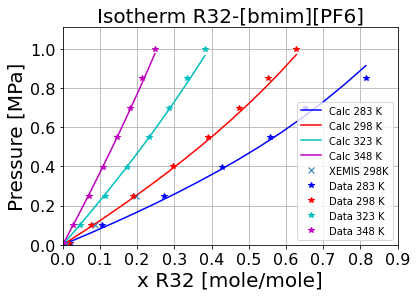

In [8]:
# for i in range(len(P)):
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

P22= np.zeros((len(P2)))

for i in range(len(P22)):
    P22[i] = P2[i]/1e6    
    
P32= np.zeros((len(P3)))

for i in range(len(P32)):
    P32[i] = P3[i]/1e6

P42= np.zeros((len(P4)))

for i in range(len(P42)):
    P42[i] = P4[i]/1e6
    
plt.plot(R32_x1,P1,"b",label="Calc 283 K")  
plt.plot(R32_x2,P22,"r",label="Calc 298 K") 
plt.plot(R32_x3,P32,"c",label="Calc 323 K") 
plt.plot(R32_x4,P42,"m",label="Calc 348 K")
plt.plot([0.088,0.198],[0.1,0.25],"x",label="XEMIS 298K")
plt.plot(data["x_R32"][0:7],data["pressure"][0:7]/1e6,"*",color='b',label="Data 283 K")  
plt.plot(data["x_R32"][7:15],data["pressure"][7:15]/1e6,"*",color='r',label="Data 298 K") 
plt.plot(data["x_R32"][15:23],data["pressure"][15:23]/1e6,"*",color='c',label="Data 323 K") 
plt.plot(data["x_R32"][23:],data["pressure"][23:]/1e6,"*",color='m',label="Data 348 K") 
plt.title('Isotherm R32-[bmim][PF6]',fontsize=20)
plt.ylabel('Pressure [MPa]',fontsize=20)
plt.xlabel('x R32 [mole/mole]',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.ylim(0,1.110000)
plt.xlim(0,0.9)
plt.legend(fontsize=10)
# plt.savefig('Isotherm R32-[bmim][PF6]_bin.png', bbox_inches='tight',dpi=300)
plt.show()

In [9]:
# print(P1)

In [10]:
df = pd.DataFrame({"P1":P1,"x1":R32_x1,"P2":P22,"x2":R32_x2,"P3":P32,"x3":R32_x3,"P4":P42,"x4":R32_x4})
# df.to_csv('P_M1_32.csv')
# df.to_csv('P_M2_32.csv')
# df.to_csv('P_M3_32.csv')
# df.to_csv('P_M4_32.csv')
df.to_csv('P_M5_32.csv')

In [11]:
print(df)

          P1        x1        P2        x2        P3        x3        P4  \
0   0.914401  0.815000  0.970440  0.628000  0.965727  0.382000  0.976313   
1   0.819971  0.758257  0.880548  0.584429  0.886192  0.355143  0.907719   
2   0.731459  0.701514  0.795767  0.540857  0.808914  0.328286  0.840238   
3   0.649630  0.644771  0.715530  0.497286  0.733738  0.301429  0.773827   
4   0.574001  0.588029  0.639316  0.453714  0.660523  0.274571  0.708445   
5   0.503777  0.531286  0.566660  0.410143  0.589142  0.247714  0.644053   
6   0.438167  0.474543  0.497160  0.366571  0.519479  0.220857  0.580615   
7   0.376474  0.417800  0.430469  0.323000  0.451428  0.194000  0.518096   
8   0.318115  0.361057  0.366287  0.279429  0.384893  0.167143  0.456464   
9   0.262611  0.304314  0.304357  0.235857  0.319785  0.140286  0.395687   
10  0.209567  0.247571  0.244458  0.192286  0.256023  0.113429  0.335737   
11  0.158662  0.190829  0.186398  0.148714  0.193534  0.086571  0.276585   
12  0.109629